# Demand-Based Pricing Optimization

### **Intro.**

#### Context
Have you ever wondered when the best time of year to book a hotel room is? Or the optimal length of stay in order to get the best daily rate? What if you wanted to predict whether or not a hotel was likely to receive a disproportionately high number of special requests?

This hotel booking dataset can help you explore those questions!

Content
This data set contains booking information for a city hotel and a resort hotel, and includes information such as when the booking was made, length of stay, the number of adults, children, and/or babies, and the number of available parking spaces, among other things.

All personally identifying information has been removed from the data.

#### What is Revenue Management
There is a key question:

    - What price should I charge for my available supply?
Revenue management is a business approach to balance supply and demand to maximize revenue.

Revenue managers have two strategic levers they can use to optimize revenue:

    - Capacity control: How many rooms to allocate to each segment
    - Pricing: What price to charge for each segment

If your hotel is one of the many that does not have a revenue management system, this workbook will provide you a simple model, that you can use as a baseline to making better pricing decisions.

#### Price Modeling and Optimal pricing

Looking at past, how many booking we could have got by dropping the rate or increasing the rate?

we need to make one key assumption:

    - Customers who paid a higher price would have paid a lower price if it had been available.

This key assumption aligns with the concept of consumer surplus in economics. Consumer surplus represents the difference between what consumers are willing to pay for a good or service and what they actually pay. When consumers pay a price lower than what they are willing to pay, they experience consumer surplus.

Maybe we study see historical data, but one shortfall in counting historical data is that we do not have the full range of possible prices. To get access to the full price spectrum, we will need to create a price model.

Price modeling answers the question:if I charge X , how many rooms will I sell? The price model will represent the relationship between a hotel's price and demand.

Typically fully deployed pricing model account for factors such as overall market demand, seasonality, competitors' pricing, Length of stay, lead times, and a myriad of other factors. As the goal of this workbook is for us to understand how price modeling and optimization work, we will focus only on seasonality and overall market demand driven by holidays.

**we keep City hotel data only**


### **imports**

In [139]:
import kagglehub
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
import warnings
import folium
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import holidays
from scipy.optimize import curve_fit
from scipy.optimize import minimize_scalar
from scipy.optimize import brentq

warnings.filterwarnings("ignore")

plt.style.use("fivethirtyeight")

%matplotlib inline


### **download dataset**

In [6]:
# Download latest version
path = kagglehub.dataset_download("jessemostipak/hotel-booking-demand")
print("Path to dataset files:", path)


def move_dataset_files(path: str):
    source_dir = f"{path}"
    project_root = os.path.split(os.getcwd())[0]  # Assumes the script is run from the project root
    destination_dir = os.path.join(project_root, "data")

    try:
        # Create the destination directory if it doesn't exist
        os.makedirs(destination_dir, exist_ok=True)
        print(f"Ensured destination directory exists: {destination_dir}")

        # Check if the source directory exists
        if not os.path.isdir(source_dir):
            print(f"Error: Source directory not found at {source_dir}")
            return

        # List all files in the source directory
        files_to_move = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]

        if not files_to_move:
            print(f"No files found in the source directory: {source_dir}")
            return

        print(f"Found {len(files_to_move)} files to move.")

        # Move each file
        for filename in files_to_move:
            source_file_path = os.path.join(source_dir, filename)
            destination_file_path = os.path.join(destination_dir, filename)

            # In case a file with the same name already exists in the destination
            if os.path.exists(destination_file_path):
                print(f"File {filename} already exists in {destination_dir}. Skipping.")
                continue

            shutil.move(source_file_path, destination_file_path)
            print(f"Moved: {filename} to {destination_dir}")

        print("Dataset moving process completed.")

    except Exception as e:
        print(f"An error occurred: {e}")


move_dataset_files(path)

100%|██████████| 1.25M/1.25M [00:00<00:00, 3.81MB/s]

Extracting files...
Path to dataset files: C:\Users\yezer\.cache\kagglehub\datasets\jessemostipak\hotel-booking-demand\versions\1
Ensured destination directory exists: c:\Users\yezer\Documents\Projects\dynamic-pricing\data
Found 1 files to move.
Moved: hotel_bookings.csv to c:\Users\yezer\Documents\Projects\dynamic-pricing\data
Dataset moving process completed.


### **load data**


In [28]:
project_root = os.path.split(os.getcwd())[0]  # Assumes the script is run from the project root
data_dir = os.path.join(project_root, "data")
df = pd.read_csv(os.path.join(data_dir, "hotel_bookings.csv"), parse_dates=True)
print(df.shape)
df.head()

(119390, 32)


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


### **eda**

Columns
- **hotel** (H1 = Resort Hotel (66%) or H2 = City Hotel (34%))
- **is_canceled** (1 = Canceled or 0 = Not Canceled)
- **lead_time** (Number of days that elapsed between the entering date of the booking into the PMS and the arrival date.)
- **arrival_date_year**
- **arrival_date_month**
- **arrival_date_week_number**
- **arrival_date_day_of_month**
- **stays_in_weekend_nights** (Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel)
- **stays_in_week_nights** (Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel)
- **adults**
- **children**
- **babies**
- **meal**: Type of meal booked. Categories are presented in standard hospitality meal packages: Undefined/SC – no meal package; BB – Bed & Breakfast; HB – Half board (breakfast and one other meal – usually dinner); FB – Full board (breakfast, lunch and dinner).
- **country**: Country of origin. Categories are represented in the ISO 3155–3:2013 format.
- **market_segment**: Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators”
- **distribution_channel**: Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators”
- **is_repeated_guest**: Value indicating if the booking name was from a repeated guest (1) or not (0)
- **previous_cancellations**: Number of previous bookings that were cancelled by the customer prior to the current booking.
- **previous_bookings_not_canceled**: Number of previous bookings not canceled by the customer prior to the current booking.
- **reserved_room_type**: Code of room type reserved.
- **assigned_room_type**: Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved.
- **booking_changes**: Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation.
- **deposit_type**: Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories: No Deposit – no deposit was made; Non Refund – a deposit was made in the value of the total stay cost; Refundable – a deposit was made with a value under the total cost of stay.
- **agent**: ID of the travel agency that made the booking
- **company**: ID of the company/entity that made the booking or responsible for paying the booking.
- **days_in_waiting_list**: Number of days the booking was in the waiting list before it was confirmed to the customer.
- **customer_type**: This column describes the nature of the booking and falls into one of four categories:
     - Contract: This type of booking is associated with a pre-negotiated contract or an allotment (a block of rooms reserved for a specific client or purpose).
     - Group: This indicates the booking is part of a larger group reservation (e.g., a tour group, a wedding party).
     - Transient: This is an individual booking that is not linked to any group, contract, or any other individual booking. It's a standalone reservation.
     - Transient-party: This booking is also an individual (transient) one, but it is connected to at least one other individual (transient) booking. This might represent a small party of individuals booking separately but known to be together, without being a formal "Group" or under a "Contract".
- **adr**: Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights.
- **required_car_parking_spaces**: Number of car parking spaces required by the customer.
- **total_of_special_requests**: Number of special requests made by the customer (e.g. twin bed or high floor).
- **reservation_status**: Reservation last status, assuming one of three categories: Canceled – booking was canceled by the customer; Check-Out – customer has checked in but already departed; No-Show – customer did not check-in and did inform the hotel of the reason why.
- **reservation_status_date**: Date at which the last status was set. This variable can be used in conjunction with the ReservationStatus to.


In [29]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


In [30]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [31]:
# checking for null values
null = pd.DataFrame(
    {"Null Values": df.isna().sum(), "Percentage Null Values": (df.isna().sum()) / (df.shape[0]) * (100)}
)
null

,Null Values,Percentage Null Values
hotel,0,0.000000
is_canceled,0,0.000000
lead_time,0,0.000000
arrival_date_year,0,0.000000
arrival_date_month,0,0.000000
arrival_date_week_number,0,0.000000
arrival_date_day_of_month,0,0.000000
stays_in_weekend_nights,0,0.000000
stays_in_week_nights,0,0.000000
adults,0,0.000000


In [32]:
percentage_zero_children = (df["children"] == 0).sum() / len(df) * 100
print(f"Percentage of bookings with 0 children: {percentage_zero_children:.2f}%")

# we could do fill the NaN in children with 0, due to the lower value of NaNs
df.fillna({"children": 0}, inplace=True)

Percentage of bookings with 0 children: 92.80%


In [33]:
# adults, babies and children cant be zero at same time,
# so dropping the rows having all these zero at same time
print(df.shape)
filter = (df.children == 0) & (df.adults == 0) & (df.babies == 0)
df[filter].head()

(119390, 32)


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
2224,Resort Hotel,0,1,2015,October,41,6,0,3,0,...,No Deposit,NaN,174.0,0,Transient-Party,0.0,0,0,Check-Out,2015-10-06
2409,Resort Hotel,0,0,2015,October,42,12,0,0,0,...,No Deposit,NaN,174.0,0,Transient,0.0,0,0,Check-Out,2015-10-12
3181,Resort Hotel,0,36,2015,November,47,20,1,2,0,...,No Deposit,38.0,NaN,0,Transient-Party,0.0,0,0,Check-Out,2015-11-23
3684,Resort Hotel,0,165,2015,December,53,30,1,4,0,...,No Deposit,308.0,NaN,122,Transient-Party,0.0,0,0,Check-Out,2016-01-04
3708,Resort Hotel,0,165,2015,December,53,30,2,4,0,...,No Deposit,308.0,NaN,122,Transient-Party,0.0,0,0,Check-Out,2016-01-05


In [34]:
print(df.shape)
df = df[~filter]
print(df.shape)

(119390, 32)
(119210, 32)


##### <span style="color:blue">where the customers come from?</span>

In [35]:
country_wise_guests = df[df["is_canceled"] == 0]["country"].value_counts().reset_index()
country_wise_guests.columns = ["country", "No of guests"]
country_wise_guests

,country,No of guests
0,PRT,20977
1,GBR,9668
2,FRA,8468
3,ESP,6383
4,DEU,6067
...,...,...
160,KIR,1
161,ATF,1
162,TJK,1
163,SLE,1


In [36]:
basemap = folium.Map()
guests_map = px.choropleth(
    country_wise_guests,
    locations=country_wise_guests["country"],
    color=country_wise_guests["No of guests"],
    hover_name=country_wise_guests["country"],
)
guests_map.show()

People from all over the world are staying in these two hotels. Most guests are from Portugal and other countries in Europe

##### <span style="color:blue">how much do guests pay for a room per night?</span>

Both hotels have different room types and different meal arrangements.Seasonal factors are also important, So the prices varies a lot.

In [37]:
data = df[df["is_canceled"] == 0]

px.box(data_frame=data, x="reserved_room_type", y="adr", color="hotel", template="plotly_dark")

##### <span style="color:blue">how does the price vary per night over the year?</span>

In [38]:
data_resort = df[(df["hotel"] == "Resort Hotel") & (df["is_canceled"] == 0)]
data_city = df[(df["hotel"] == "City Hotel") & (df["is_canceled"] == 0)]

In [39]:
resort_hotel = data_resort.groupby(["arrival_date_month"])["adr"].mean().reset_index()
# Define the order of months
month_order = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]

# Convert 'arrival_date_month' to a categorical type with the defined order
resort_hotel["arrival_date_month"] = pd.Categorical(
    resort_hotel["arrival_date_month"], categories=month_order, ordered=True
)

# Sort by month
resort_hotel_sorted = resort_hotel.sort_values("arrival_date_month")
resort_hotel_sorted

,arrival_date_month,adr
4,January,48.761125
3,February,54.147478
7,March,57.056838
0,April,75.867816
8,May,76.657558
6,June,107.974850
5,July,150.122528
1,August,181.205892
11,September,96.416860
10,October,61.775449


In [40]:
city_hotel = data_city.groupby(["arrival_date_month"])["adr"].mean().reset_index()

# Convert 'arrival_date_month' to a categorical type with the defined order
city_hotel["arrival_date_month"] = pd.Categorical(
    city_hotel["arrival_date_month"], categories=month_order, ordered=True
)

# Sort by month
city_hotel_sorted = city_hotel.sort_values("arrival_date_month")
city_hotel_sorted

,arrival_date_month,adr
4,January,82.330983
3,February,86.520062
7,March,90.658533
0,April,111.962267
8,May,120.669827
6,June,117.874360
5,July,115.818019
1,August,118.674598
11,September,112.776582
10,October,102.004672


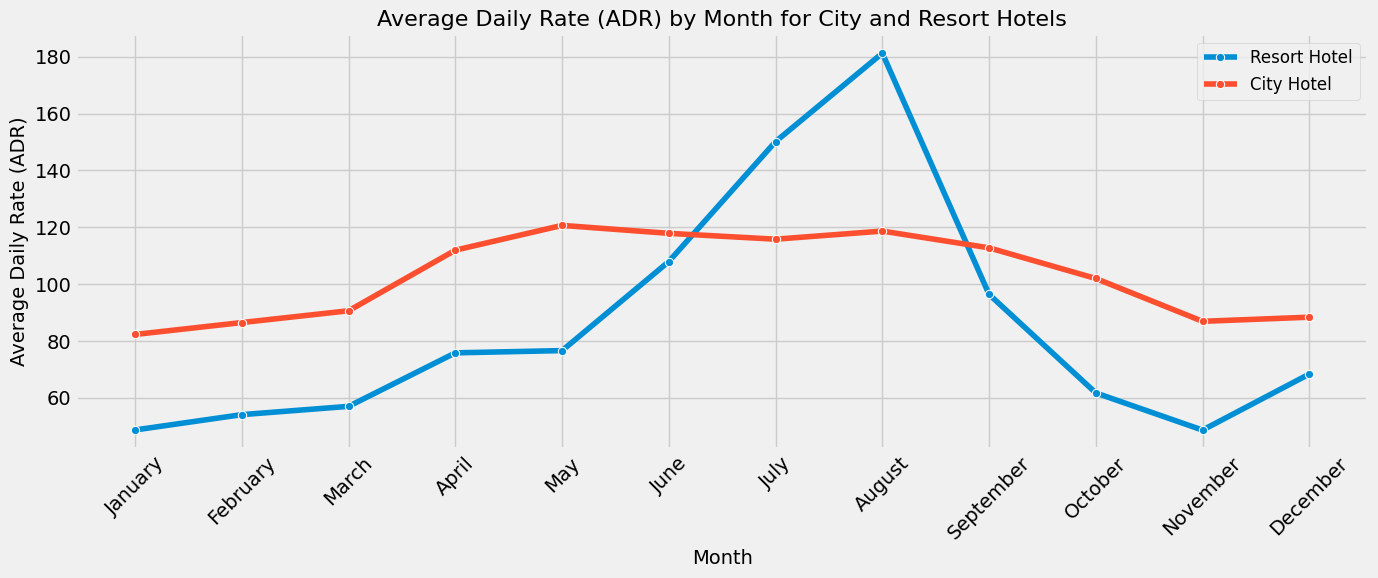

In [41]:
plt.figure(figsize=(14, 6))
plt.title("Average Daily Rate (ADR) by Month for City and Resort Hotels", fontsize=16)

# Plot for Resort Hotel
sns.lineplot(
    x=resort_hotel_sorted["arrival_date_month"], y=resort_hotel_sorted["adr"], label="Resort Hotel", marker="o"
)

# Plot for City Hotel
sns.lineplot(x=city_hotel_sorted["arrival_date_month"], y=city_hotel_sorted["adr"], label="City Hotel", marker="o")

plt.xlabel("Month", fontsize=14)
plt.ylabel("Average Daily Rate (ADR)", fontsize=14)
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


This plot clearly shows that prices in the Resort Hotel are much higher during the summer and prices of city hotel varies less and is most expensive during Spring and Autumn .

##### <span style="color:blue">Which are the most busy months?</span>

In [42]:
resort_guests = data_resort["arrival_date_month"].value_counts().reset_index()
resort_guests.columns = ["month", "no of guests"]
resort_guests

,month,no of guests
0,August,3257
1,July,3137
2,October,2575
3,March,2571
4,April,2550
5,May,2535
6,February,2308
7,September,2102
8,June,2037
9,December,2014


In [43]:
city_guests = data_city["arrival_date_month"].value_counts().reset_index()
city_guests.columns = ["month", "no of guests"]
city_guests

,month,no of guests
0,August,5367
1,July,4770
2,May,4568
3,June,4358
4,October,4326
5,September,4283
6,March,4049
7,April,4010
8,February,3051
9,November,2676


In [44]:
final_guests = resort_guests.merge(city_guests, on="month")
final_guests.columns = ["month", "no of guests in resort", "no of guest in city hotel"]
# Define the correct order of months
month_order = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]

# Convert 'month' column to categorical with the defined order
final_guests["month"] = pd.Categorical(final_guests["month"], categories=month_order, ordered=True)

# Sort the DataFrame by month
final_guests_sorted = final_guests.sort_values("month")

# Reset the index
final_guests_sorted = final_guests_sorted.reset_index(drop=True)

final_guests_sorted

,month,no of guests in resort,no of guest in city hotel
0,January,1866,2249
1,February,2308,3051
2,March,2571,4049
3,April,2550,4010
4,May,2535,4568
5,June,2037,4358
6,July,3137,4770
7,August,3257,5367
8,September,2102,4283
9,October,2575,4326


In [45]:
fig = px.line(
    final_guests_sorted,
    x="month",
    y=["no of guests in resort", "no of guest in city hotel"],
    template="plotly_dark",
)

# Get the colors assigned by px.line to the first two traces
# fig.data[0] corresponds to "no of guests in resort"
# fig.data[1] corresponds to "no of guest in city hotel"
resort_color = fig.data[0].line.color
city_color = fig.data[1].line.color

fig.add_trace(
    go.Scatter(
        x=final_guests_sorted["month"],
        y=resort_hotel_sorted[
            "adr"
        ],  # Assumes resort_hotel_sorted is available and its 'adr' column is correctly ordered
        name="ADR Resort Hotel",
        yaxis="y2",
        line=dict(color=resort_color),  # Match color with resort guests line
    )
)

fig.add_trace(
    go.Scatter(
        x=final_guests_sorted["month"],
        y=city_hotel_sorted["adr"],  # Assumes city_hotel_sorted is available and its 'adr' column is correctly ordered
        name="ADR City Hotel",
        yaxis="y2",
        line=dict(color=city_color),  # Match color with city guests line
    )
)

fig.update_layout(
    title_text="Total Guests and ADR per Month",
    xaxis_title="Month",
    yaxis_title="Number of Guests",
    yaxis2=dict(
        title="ADR",
        overlaying="y",
        side="right",
    ),
    legend_title_text="Metrics",
    legend=dict(
        x=1.05,  # Position legend outside the plot on the right
        y=1,
        traceorder="normal",
        font=dict(family="sans-serif", size=12, color="white"),
        bordercolor="Black",
        borderwidth=2,
    ),
)

The resort has a little customer decrease in June and September, where prices are high.
Both hotels have the fewest guests during the winter.

##### <span style="color:blue">How long do people stay at the hotels?</span>

In [46]:
filter = df["is_canceled"] == 0
data = df[filter]
data["total_nights"] = data["stays_in_weekend_nights"] + data["stays_in_week_nights"]
stay = data.groupby(["total_nights", "hotel"]).agg("count").reset_index()
stay = stay.iloc[:, :3]
stay = stay.rename(columns={"is_canceled": "Number of stays"})
stay

,total_nights,hotel,Number of stays
0,0,City Hotel,251
1,0,Resort Hotel,371
2,1,City Hotel,9155
3,1,Resort Hotel,6579
4,2,City Hotel,10983
...,...,...,...
57,46,Resort Hotel,1
58,48,City Hotel,1
59,56,Resort Hotel,1
60,60,Resort Hotel,1


In [47]:
px.bar(data_frame=stay, x="total_nights", y="Number of stays", color="hotel", barmode="group", template="plotly_dark")

### **data cleaning**

In [48]:
# remove Cancelations and no-shows and keep City hotel data only
df = df[(df["is_canceled"] == 0) & (df["reservation_status"] != "No-Show")]
df = df[df.hotel == "City Hotel"]
print(df.shape)

(46084, 32)


In [49]:
df.groupby(["market_segment", "reserved_room_type"]).agg({"adr": "mean", "reservation_status_date": "count"})

adr  reservation_status_date
market_segment reserved_room_type                                     
Aviation       A                    93.608500                      100
               D                   107.713951                       81
               E                   159.250000                        2
Complementary  A                     3.619128                      298
               B                     0.076190                       21
               C                     0.000000                        2
               D                     1.754386                       57
               E                     4.782609                       23
               F                     0.000000                       22
               G                     0.020833                       48
Corporate      A                    79.366243                     2095
               B                    45.416667                        3
               C                   110.000000                        1
               D                    99.250714                      140
               E                   114.699438                       89
               F                   114.690000                        3
               G                   139.166667                        6
Direct         A                   105.816918                     3215
               B                    91.523316                      193
               C                    74.000000                        1
               D                   130.442451                      918
               E                   162.507282                      412
               F                   174.163125                      144
               G                   235.700902                      133
Groups         A                    84.486292                     4258
               B                    92.000000                        6
               C                   104.000000                        1
               D                    87.045652                       69
               E                    80.000000                        2
               F                   123.000000                        2
               G                   250.000000                        1
Offline TA/TO  A                    89.511736                     8635
               B                    75.127755                       49
               C                   108.333333                        3
               D                    89.209597                      744
               E                   126.919872                       78
               F                   137.422000                       25
               G                   204.567500                       12
Online TA      A                   105.886546                    16640
               B                    91.254482                      473
               D                   136.113585                     5592
               E                   168.265949                      432
               F                   193.789283                      892
               G                   221.046074                      163

To remove as much noise as possible, we will focus only on direct bookings and online TA, as these are the publicly available rates to everyone. In the other cases, the politics maybe different and we are interested in capture the price the customer is willing to pay.

To create our pricing model, we need to optimize the room type level. We are interested in the room type reserved as this captures the price the guest was willing to pay for that room type.

Unfortunately, there is not much description of the reserved room type, but by looking at the price points, we can infer that A &B are the lowest price points. The rest of the room types command a higher ADR, which means they likely are upgraded rooms. In another workbook, we will explore how to price those premium rooms, but for the moment, let's focus on room types A & B.

In [50]:
data = df[(df.market_segment == "Direct") | (df.market_segment == "Online TA")]

data = data[(data.reserved_room_type == "A") | (data.reserved_room_type == "B")]

data.reserved_room_type.value_counts()

reserved_room_type
A    19855
B      666
Name: count, dtype: int64

In [51]:
# lets create a arrival date column
data["date"] = pd.to_datetime(
    data["arrival_date_year"].astype(str)
    + "-"
    + data["arrival_date_month"]
    + "-"
    + data["arrival_date_day_of_month"].astype(str)
)
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,date
40085,City Hotel,0,60,2015,July,27,3,2,5,2,...,11.0,NaN,0,Transient,60.27,0,0,Check-Out,2015-07-10,2015-07-03
40113,City Hotel,0,54,2015,July,28,7,2,8,2,...,7.0,NaN,0,Transient,62.37,0,0,Check-Out,2015-07-17,2015-07-07
40121,City Hotel,0,72,2015,July,28,8,1,4,2,...,8.0,NaN,0,Transient,76.50,0,0,Check-Out,2015-07-13,2015-07-08
40127,City Hotel,0,92,2015,July,28,9,2,3,2,...,7.0,NaN,0,Transient,58.90,0,1,Check-Out,2015-07-14,2015-07-09
40135,City Hotel,0,71,2015,July,28,11,0,1,1,...,11.0,NaN,0,Transient,51.96,0,0,Check-Out,2015-07-12,2015-07-11


##### **Transforming data from arrival date to stay date**

The pricing model we are building optimizes at the stay-day level. However, the current dataset only has an Arrival date. Why is this an issue? Imagine we have a booking arriving on Friday for 3 days at 100. If we count the rate frequency at the arrival date, we will get 1 room demand at 100 for Friday, but what about Saturday and Sunday? With the current arrival setup, we would say there was no demand for 100 on those days; however, we know there is demand.

In order to count this demand, we need to transform our data from arrival date to stay date.

In [52]:
# get the total room nights stayed based on arrival date
data['total_rns'] = data['stays_in_week_nights'] + data['stays_in_weekend_nights']

#filter, to date, rns and ADR only
data_to_transform = data[['date','total_rns','adr']]
data_to_transform

,date,total_rns,adr
40085,2015-07-03,7,60.27
40113,2015-07-07,10,62.37
40121,2015-07-08,5,76.50
40127,2015-07-09,5,58.90
40135,2015-07-11,1,51.96
...,...,...,...
119377,2017-08-30,5,99.00
119380,2017-08-31,4,140.75
119381,2017-08-31,5,99.00
119388,2017-08-31,7,104.40


In [94]:
# Create a new dataframe to store the data by stay date
expanded_df = pd.DataFrame()

# Iterate over each row in the arrival date

for _, row in data.iterrows():
    # Get the number of stay dates for the current booking
    num_stay_dates = row["total_rns"]

    # Create a row for each stay date
    expanded_booking = pd.DataFrame(
        {"date": pd.date_range(start=row["date"], periods=num_stay_dates), "rn": 1, "adr": row["adr"]}
    )

    # Append the stay date information to the new dataframe
    expanded_df = pd.concat([expanded_df, expanded_booking], ignore_index=True)


# Sort the final dataframe by date
expanded_df = expanded_df.sort_values("date")
expanded_df = expanded_df.reset_index(drop=True)
#round rates for ease of counting
expanded_df['adr']= round(expanded_df['adr'])

expanded_df

,date,rn,adr
0,2015-07-01,1,112.0
1,2015-07-01,1,76.0
2,2015-07-02,1,112.0
3,2015-07-02,1,76.0
4,2015-07-03,1,76.0
...,...,...,...
60120,2017-09-04,1,104.0
60121,2017-09-05,1,104.0
60122,2017-09-05,1,151.0
60123,2017-09-06,1,104.0


##### **Building seasonality**

Hotel prices vary by season; therefore, it is essential that our model accounts for this. While we will take care of major seasonality by doing our dynamic pricing at the DOW and Month level, some special holidays could impact those results. These holidays influence our demand, so our pricing should reflect the specific demand levels for those days.

When modeling the holiday demand, we need to account that the impact is not only on the day itself, but the holiday could affect the surrounding days.

The hotel from this data set is located in Portugal; while there are many holidays, we will focus on the key holidays: Easter, Christmas, and New Year's.

When building a model for your hotel, you must evaluate which holidays impact your demand and account for those.

In [54]:
holiday_dates = holidays.CountryHoliday('PT', years=[2015,2016,2017])
holidays = {
    date: name
    for date, name in holiday_dates.items()
    if name in ['Ano Novo', 'Páscoa', 'Dia de Natal']
}
holidays


{datetime.date(2016, 1, 1): 'Ano Novo',
 datetime.date(2016, 3, 27): 'Páscoa',
 datetime.date(2016, 12, 25): 'Dia de Natal',
 datetime.date(2017, 1, 1): 'Ano Novo',
 datetime.date(2017, 4, 16): 'Páscoa',
 datetime.date(2017, 12, 25): 'Dia de Natal',
 datetime.date(2015, 1, 1): 'Ano Novo',
 datetime.date(2015, 4, 5): 'Páscoa',
 datetime.date(2015, 12, 25): 'Dia de Natal'}

In [95]:
# Define pre and post ranges for each holiday
pre_range_offset = {
    "Ano Novo": relativedelta(days=-1),
    "Páscoa": relativedelta(days=-2),
    "Dia de Natal": relativedelta(days=-3),
}

post_range_offset = {
    "Ano Novo": relativedelta(days=1),
    "Páscoa": relativedelta(days=2),
    "Dia de Natal": relativedelta(days=3),
}

# Create new columns for each holiday
for holiday in holidays.values():
    expanded_df[holiday] = 0

for holiday_date, holiday_name in holidays.items():
    # Get the specific pre and post offsets for this holiday
    pre_offset = pre_range_offset[holiday_name]
    post_offset = post_range_offset[holiday_name]

    # Calculate the start and end dates of the holiday influence period
    # holiday_date is a datetime.date object. Adding relativedelta results in a datetime.date object.
    start_date_period = holiday_date + pre_offset
    end_date_period = holiday_date + post_offset

    # expanded_df['date'] is a pandas Series of Timestamps.
    # Comparing its .dt.date (which are datetime.date objects) with start_date_period and end_date_period.
    date_mask = (expanded_df["date"].dt.date >= start_date_period) & (expanded_df["date"].dt.date <= end_date_period)

    # Set the corresponding holiday column to 1 for rows falling within the period
    expanded_df.loc[date_mask, holiday_name] = 1


# rename holiday columns
expanded_df = expanded_df.rename({"Ano Novo": "new_years", "Páscoa": "easter", "Dia de Natal": "christmas"}, axis=1)

expanded_df.head()

,date,rn,adr,new_years,easter,christmas
0,2015-07-01,1,112.0,0,0,0
1,2015-07-01,1,76.0,0,0,0
2,2015-07-02,1,112.0,0,0,0
3,2015-07-02,1,76.0,0,0,0
4,2015-07-03,1,76.0,0,0,0


In [ ]:
# The following lines add new columns to the 'expanded_df' DataFrame based on its 'date' column.
# The 'date' column is assumed to contain datetime-like objects.

# Create a new column named 'dow' (day of week).
# For each date in the 'expanded_df.date' column:
# 1. `.dt` accessor is used to access datetime-like properties of the Series.
# 2. `.strftime('%A')` formats the date into the full weekday name (e.g., "Monday", "Tuesday", ...).
# The resulting Series of weekday names is assigned to the new 'dow' column.
expanded_df['dow'] = expanded_df.date.dt.strftime('%A')

# Create a new column named 'month'.
# For each date in the 'expanded_df.date' column:
# 1. `.dt` accessor is used to access datetime-like properties of the Series.
# 2. `.strftime('%B')` formats the date into the full month name (e.g., "January", "February", ...).
# The resulting Series of month names is assigned to the new 'month' column.
expanded_df['month'] = expanded_df.date.dt.strftime('%B')

expanded_df.head()

### **first pricing model**

In [116]:
#Remove holidays for our main model. I think they are not needed for the first model for simplicity.
non_holidays = expanded_df[expanded_df[['new_years', 'easter', 'christmas']].sum(axis=1) == 0]
non_holidays.head()

,date,rn,adr,new_years,easter,christmas,dow,month
0,2015-07-01,1,112.0,0,0,0,Wednesday,July
1,2015-07-01,1,76.0,0,0,0,Wednesday,July
2,2015-07-02,1,112.0,0,0,0,Thursday,July
3,2015-07-02,1,76.0,0,0,0,Thursday,July
4,2015-07-03,1,76.0,0,0,0,Friday,July


Our optimization will be done at the DOW and Month Level.

As a reminder, we are trying to model the relationship between Price and Demand so that we can answer the below question:

if I charge X , how many rooms will I sell?

To begin with, we need to get the demand levels for each DOW and month as well as create a table counting how many times each price point appears for each DOW and month.

In [117]:
daily_rns = non_holidays.groupby(["date", "dow", "month"]).agg({"rn": "sum"}).reset_index()  # ge total stays per day

daily_rns = (
    daily_rns.groupby(["dow", "month"]).agg({"rn": ["sum", "mean", "median"]}).reset_index()
)  # get Rns metrics by Dow & Month

daily_rns.columns = ["_".join(col) for col in daily_rns.columns]  # remove multi level column
daily_rns

,dow_,month_,rn_sum,rn_mean,rn_median
0,Friday,April,712,89.000000,97.0
1,Friday,August,1025,85.416667,86.0
2,Friday,December,370,52.857143,49.0
3,Friday,February,601,75.125000,70.5
4,Friday,January,484,60.500000,57.5
...,...,...,...,...,...
79,Wednesday,March,894,89.400000,94.0
80,Wednesday,May,738,82.000000,77.0
81,Wednesday,November,591,65.666667,56.0
82,Wednesday,October,610,76.250000,85.0


The table above shows that on Fridays during April, the hotels typically sell 89 rooms. However, there seem to be some outliers with low values because the median room sold is 98.

This data will serve us at a later stage to calculate the probabilities and expected demand.

The next step is to get the rate frequency table.

**Counting rate frequency**

In the next step, we will count how often each adr (price the guest paid) appears for each DOW and month.

In [119]:
# create rate frequency table
adr_frequency = non_holidays.groupby(['dow','month','adr']).agg({'rn':'sum'})
adr_frequency.reset_index(inplace=True)
adr_frequency.head(10)

,dow,month,adr,rn
0,Friday,April,0.0,3
1,Friday,April,12.0,2
2,Friday,April,50.0,1
3,Friday,April,52.0,2
4,Friday,April,53.0,1
5,Friday,April,54.0,3
6,Friday,April,56.0,3
7,Friday,April,59.0,2
8,Friday,April,63.0,2
9,Friday,April,64.0,2


The above table shows that in our data, we counted 3 times the rate of 54 on April's Fridays. We can use this data for modeling demand as a function of price.

So far, we have counted observations. However, we do not have an estimated number of rooms we could sell for any given day. Moreover, we have not prepared our data to reflect our key assumption:

    - Customers who paid a higher price would have paid a lower price if it had been available.

To continue with our Pricing model, we need to introduce the concept of expected value.

**Expected Value**

Expected value is a fundamental idea in statistics and probability theory; it is used in various industries to help make predictions and decisions in situations where there is uncertainty or randomness.

The concept of expected value is like taking an educated guess about what you might expect to happen on average in a situation with some randomness or uncertainty.

In Revenue Management, we are faced with making decisions every day, to avoid making decisions that rely on our own biased mental model, we rely on applying decision theory.

In decision theory, the concept of expected value is a fundamental tool used to make rational choices in situations where there is uncertainty or risk. Decision theory is concerned with how individuals or organizations should make decisions when they have multiple options, each associated with uncertain outcomes and potentially different payoffs or costs.

In decision theory, you can evaluate alternatives by calculating the expected value for each one. The expected value is a way to quantify the average or expected outcome for each alternative.

Mathematically, for a given alternative:

Expected Value (EV) = Σ [Outcome * Probability]

We will use the Expected Value theory and turn our pricing decision problem into an optimization problem.

In our case, we will start by calculating the relative frequency of each rate and use that as our probability. Relative frequency is equal to the probability in this context because we assume that the relative frequency of each rate in the data represents the probability of observing that rate in the future.

Moreover, we want to give more weight to more frequent rates. As a result, we will multiply the median room nights by the relative frequency "relative_frequency" for each rate. This gives us a weighted estimate of the expected value for each rate.



In [120]:
# combine ADR frequency with Total Rns stats to calculate probabilities

merged_df = pd.merge(
    adr_frequency,
    daily_rns,
    how="left",
    left_on=["dow", "month"],
    right_on=["dow_", "month_"],
    suffixes=("_act", "_tot"),
)

merged_df = merged_df.drop(["dow_", "month_"], axis=1)

merged_df

,dow,month,adr,rn,rn_sum,rn_mean,rn_median
0,Friday,April,0.0,3,712,89.0,97.0
1,Friday,April,12.0,2,712,89.0,97.0
2,Friday,April,50.0,1,712,89.0,97.0
3,Friday,April,52.0,2,712,89.0,97.0
4,Friday,April,53.0,1,712,89.0,97.0
...,...,...,...,...,...,...,...
8516,Wednesday,September,190.0,1,584,58.4,54.0
8517,Wednesday,September,191.0,1,584,58.4,54.0
8518,Wednesday,September,195.0,1,584,58.4,54.0
8519,Wednesday,September,200.0,3,584,58.4,54.0


In [121]:
#add propability/ Relative frequency
merged_df['probability'] = merged_df['rn']/merged_df['rn_sum']

In [122]:
# Calculates the weighted expected rns that we will use for our calculations
merged_df['expected_rns'] = merged_df['probability'] * merged_df['rn_median']

In [123]:
merged_df

,dow,month,adr,rn,rn_sum,rn_mean,rn_median,probability,expected_rns
0,Friday,April,0.0,3,712,89.0,97.0,0.004213,0.408708
1,Friday,April,12.0,2,712,89.0,97.0,0.002809,0.272472
2,Friday,April,50.0,1,712,89.0,97.0,0.001404,0.136236
3,Friday,April,52.0,2,712,89.0,97.0,0.002809,0.272472
4,Friday,April,53.0,1,712,89.0,97.0,0.001404,0.136236
...,...,...,...,...,...,...,...,...,...
8516,Wednesday,September,190.0,1,584,58.4,54.0,0.001712,0.092466
8517,Wednesday,September,191.0,1,584,58.4,54.0,0.001712,0.092466
8518,Wednesday,September,195.0,1,584,58.4,54.0,0.001712,0.092466
8519,Wednesday,September,200.0,3,584,58.4,54.0,0.005137,0.277397


We have calculated the expected room nights for each price; however, we still need to apply our key assumption to estimate the demand for each price point.

    - Customers who paid a higher price would have paid a lower price if it had been available.

We will create a cumulative sum of the expected room nights at each price point to include this assumption in our table.

In [124]:
merged_df = merged_df.sort_values(by=["dow", "month", "adr"], ascending=[True, True, False])
# fundamental assumption of demand: People who paid the higher price would have paid a lower price if available
merged_df["expected_demand"] = merged_df.groupby(["dow", "month"])["expected_rns"].cumsum()
merged_df.head(10)

In [125]:
merged_df.head(10)

,dow,month,adr,rn,rn_sum,rn_mean,rn_median,probability,expected_rns,expected_demand
107,Friday,April,197.0,1,712,89.0,97.0,0.001404,0.136236,0.136236
106,Friday,April,189.0,2,712,89.0,97.0,0.002809,0.272472,0.408708
105,Friday,April,184.0,2,712,89.0,97.0,0.002809,0.272472,0.681180
104,Friday,April,180.0,1,712,89.0,97.0,0.001404,0.136236,0.817416
103,Friday,April,179.0,1,712,89.0,97.0,0.001404,0.136236,0.953652
102,Friday,April,178.0,2,712,89.0,97.0,0.002809,0.272472,1.226124
101,Friday,April,170.0,2,712,89.0,97.0,0.002809,0.272472,1.498596
100,Friday,April,167.0,1,712,89.0,97.0,0.001404,0.136236,1.634831
99,Friday,April,165.0,1,712,89.0,97.0,0.001404,0.136236,1.771067
98,Friday,April,162.0,1,712,89.0,97.0,0.001404,0.136236,1.907303


The table above shows that at the price of 197 on a Friday in April, we can expect to sell 0 rooms, and at 178, we can expect to sell 1 room.

So far, we have applied the expected value theory to estimate demand. Now, we are going to use the same theory to calculate the expected revenue and turn this into a revenue optimization problem.

The formula we are going to use to calculate the expected revenue is:

Expected Revenue = ADR * expected demand

Let's start by looking at this visually.

**Visual optimization**

We will start by plotting the demand curve and then try to find the price that maximizes expected revenue.

In [ ]:
# calculating expect Rev
merged_df["expected_rev"] = merged_df["adr"] * merged_df["expected_demand"]
fig = px.line(merged_df[(merged_df.dow == "Friday") & (merged_df.month == "April")], 
              x="adr", 
              y="expected_demand", 
              title="Demand Curve for Friday in April")
fig.show()

The graphs represent a typical demand curve; demand decreases as price/adr increases. We know that the Expected revenue is a function of both price and demand, so we can explore the expected revenue curve and optimize it by finding the inflection point.

In [ ]:
fig = px.line(merged_df[(merged_df.dow == "Friday") & (merged_df.month == "April")], 
              x="adr", 
              y="expected_rev", 
              title="Inflection point")
fig.show()


Visually, we can see that the expected revenue is optimized at a price of around 75 to 85. Let’s look at our table to get the exact value.

In [129]:
fri_april = merged_df[(merged_df.dow == 'Friday') & (merged_df.month =='April')].reset_index()

# Gets the max expected rev
fri_april[fri_april.expected_rev == fri_april.expected_rev.max()]

,index,dow,month,adr,rn,rn_sum,rn_mean,rn_median,probability,expected_rns,expected_demand,expected_rev
81,26,Friday,April,81.0,8,712,89.0,97.0,0.011236,1.089888,82.967697,6720.383427


We have manually established that the optimal rate for Fridays in April is 81. At this rate we can expect to sell 83 Rooms. 

We might get more room nights if we decrease the price to 74. However, the increase in room nights is insufficient to compensate for the rate drop.

This brings me back to the experience I described in the initial story. I was suggesting dropping the rates. However, the historical demand showed that while we might have increased the room nights a bit, the drop in rate would have put the hotel below its maximum expected revenue.

So far, we have explored the key concept of revenue optimization through pricing. Still, we have done all the work manually.

The next step is to use the power of statistics and optimization to create a demand curve.

**Price optimization model**

Before we build our model, we need to deal with outliers, as those could impact our demand curve calculations.

Dealing with Outliers
We will use the z-scores to calculate each data point's distance from the mean and set our threshold at 2.

We are taking a simplistic approach and removing the outliers as the goal of this notebook is to explain the key concepts of revenue optimization; however, you might have a different approach to dealing with outliers, depending on your objective.

In [130]:
mean = fri_april.adr.mean()
std_dev = fri_april.adr.std()

# Use z-scores
fri_april['z_scores'] = np.abs((fri_april.adr - mean) / std_dev)
fri_april = fri_april[fri_april.z_scores<=2]

##### **Fitting a demand curve**

In the next step, we will mathematically define the demand curve and fit that function to the actual observed demand we have calculated before. To do so, we are using scipy module.

This step will require experimentation with different demand curve functions and initial parameters. After much experimentation, I choose the demand curve I will show below. However, this is not the only possible demand curve definition. Moreover, while I am using Scipy to fit the demand curve, you could use different machine learning models. Depending on the model you choose, the below steps will be different.

For my demand curve, I used an exponential demand function, often used in economics and business, to model how the quantity demanded of a product or service changes with price.

In [134]:
# Define the demand curve function
def demand_curve(x, a, b, c, d, max_demand):
    demand = a * np.exp(-b * x) + c
    demand = np.where(x <= max_demand, np.minimum(demand, max_demand), demand)
    return demand + d

# Convert dataframe columns to numpy arrays
x_data = fri_april['adr'].values
y_data = fri_april['expected_demand'].values


initial_guess = [1, 0.01, 1, 1, 100]
bounds = ([0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf])

# Fit the demand curve to the data
params, _ = curve_fit(demand_curve, x_data, y_data, bounds=bounds, p0=initial_guess)

# Extract the fitted parameters
a_fit, b_fit, c_fit ,d_fit,max_demand= params

The demand_curve function represents a demand curve, incorporating additional parameters and constraints. Here's an explanation of the components of this function:

x: Price

a, b, c, d: These are parameters that control the shape and behavior of the demand curve.

'a' affects the amplitude or scale of the demand curve.
'b' determines the rate of decrease in demand as 'x' increases.
'c' represents factors other than 'x' (price) that can affect demand.
'd' represents an additional constant that can shift the entire demand curve up or down.
max_demand: It defines a maximum demand level, and the demand curve is constrained not to exceed this value. This is a manual addition to avoid having unrealistically high values at very low prices - this is a business constraint, as the hotel would not sell at low rates, such as 10 or 5, even if the demand was extremely high. This step is not necessary, and I could have used another demand function instead. However, in the interest of time, I added this constraint.

demand = a np.exp(-b x) + c: This is the core of the demand curve equation, representing the basic demand behavior.

np.where(x <= max_demand, np.minimum(demand, max_demand), demand): This part of the code is applying a constraint to the demand curve. It checks if 'x' (price) is less than or equal to 'max_demand' and, if so, replaces the demand with the minimum value between the calculated demand and 'max_demand.' This ensures that the demand doesn't exceed 'max_demand' when 'x' is within that range.

In [140]:
predicted_demand = demand_curve(x_data, a_fit, b_fit,c_fit,d_fit,max_demand)

# Create a scatter plot for the actual demand
scatter_trace = go.Scatter(x=x_data, y=y_data, mode='markers', name='Actual Demand')

# Create a line plot for the fitted curve
# It's better to sort x_data for a smooth line plot if it's not already sorted
sorted_indices = np.argsort(x_data)
sorted_x_data = x_data[sorted_indices]
sorted_predicted_demand = predicted_demand[sorted_indices]
line_trace = go.Scatter(x=sorted_x_data, y=sorted_predicted_demand, mode='lines', name='Fitted Curve')

# Create the figure and add the traces
fig = go.Figure(data=[scatter_trace, line_trace])

# Update the layout
fig.update_layout(
    title='Demand Curve Fit',
    xaxis_title='Price',
    yaxis_title='Demand',
    legend_title='Legend'
)

# Show the plot
fig.show()

##### **The revenue function**

As we can see, our demand curve fits pretty closely with the demand data. The fit is not perfect, and with more experimentation, we could have achieved a better result; however, the results will help us explain the remaining steps in our pricing optimization model.

The next step is to use this defined demand curve to calculate the revenue for each price point to optimize the Revenue function, similar to what we did manually in the steps above.

The Revenue is simply defined as the Price * Demand.

Now, we can turn our pricing model into a when you have a one-dimensional optimization problem. We want the price that maximizes the revenue function.

To achieve this, we will use the function minimize_scalar from scipy. As the name implies, this function is used to minimize the function, so to maximize the Revenue function using minimize_scalar, we can minimize the negative of the revenue function.

This is a necessary workaround because scipy does not have a maximum scalar function.

In [137]:
def revenue(price):
    return price * demand_curve(price, a_fit, b_fit,c_fit,d_fit,max_demand)

#Define the objective function to maximize (negative revenue to convert maximization to minimization problem)
# objective = lambda price: -revenue(price)
def objective(price):
    return -revenue(price)

result = minimize_scalar(objective, bounds=(60, 180), method='bounded')
optimal_price = result.x
max_revenue = -result.fun
room_sold = demand_curve(optimal_price, a_fit, b_fit,c_fit,d_fit,max_demand)

print(f"The optimal price to maximize revenue: ${optimal_price}")
print(f"The maximum revenue achievable: ${max_revenue}")
print(f"The expected number of rooms to sell: {room_sold}")

The optimal price to maximize revenue: $81.67373348686948
The maximum revenue achievable: $7435.883494192787
The expected number of rooms to sell: 91.04375637962282


As we can see, our optimal price that maximizes revenue is 82, which is very similar to the optimal price we established manually. At this price, we can expect to sell 91 rooms.

One natural question you could ask is: What if I don't have 91 rooms left to sell? What if I only have 50 rooms to sell? Typically, the fewer available rooms for sale, the higher the rate you can command. So, while the price of 81 can be optimal, we could increase the price to account for our limited inventory.

We know the expected demand for each price point, so if we only have 50 rooms to sell, we can find the price point that will yield 50 rooms of demand.

We need to create a formula to turn demand into price to find this.

In [141]:
def demand_to_price(num_rooms, a, b, c, d, max_demand):
   
    def root_func(x):
        return num_rooms - (a * np.exp(-b * x) + c)
    
    # Find the price using numerical root finding
    price = brentq(root_func, 0, 200)  # Adjust the interval bounds as needed
    
    return price

demand_to_price(50,a_fit,b_fit,c_fit,d_fit,max_demand)

97.76710200712013

**Model limitations and simplifications**

In this example, we have simplified the problem by not accounting for lead times and booking windows, as the objective is to explain how pricing models in the hotel industry work.

Lead time is an essential factor to consider if you are going to deploy your pricing model, as your pricing would be very different if you had 50 rooms left to sell 90 days before arrival or if you had 50 rooms left to sell on the arrival day.

We could perform the same model above only with holiday data.